In [23]:
# AUDIO_DIR = "/Users/zainhazzouri/projects/Bachelor_Thesis/Data/Kaggle/"
SAMPLE_RATE = 22050 # sample rate of the audio file
bit_depth = 16 # bit depth of the audio file
hop_length = 512
n_mfcc =  20 # number of MFCCs features
n_fft=1024, # window size
n_mels = 256 # number of mel bands to generate
win_length = None # window length


# Training parameters
batch_size = 64
learning_rate = 0.001
num_epochs = 20




In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, matthews_corrcoef,confusion_matrix
import torchaudio



from cnn_model import CNNModel
from datapreprocessing import AudioProcessor


In [25]:
# Set device
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_built():  # if you have apple silicon mac
    device = "mps"  # if it doesn't work try device = torch.device('mps')
else:
    device = "cpu"
print(f"Using {device}")

Using mps


In [26]:

# Define a function to load the waveform and the sample rate from a file
# def load_waveform(file_path):
#     waveform, sample_rate = torchaudio.load(file_path)
#     return waveform, sample_rate

path_to_train = "/Users/zainhazzouri/projects/Bachelor_Thesis/Data/train/"
path_to_test = "/Users/zainhazzouri/projects/Bachelor_Thesis/Data/test/"

train_dataset = AudioProcessor(audio_dir=path_to_train)
val_dataset = AudioProcessor(audio_dir=path_to_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)







# # Create an instance of AudioProcessor
# audio_processor = AudioProcessor(AUDIO_DIR)
#
# # Create the dataset using the audio_processor instance
# dataset = audio_processor


# # Split the dataset into training and validation sets
# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
#
# # Create DataLoader
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss, and optimizer
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [30]:
def calculate_sdr(target, prediction):
    target = target.float()
    prediction = prediction.float()
    target_energy = torch.sum(target**2)
    error_signal = target - prediction
    error_energy = torch.sum(error_signal**2)
    sdr = 10 * torch.log10(target_energy / error_energy)
    return sdr.item()


In [34]:
def one_hot_encode(labels, num_classes):
    return torch.eye(num_classes)[labels]


In [41]:
def evaluate(val_loader, model, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_targets = []
    all_predictions = []
    all_sdrs = []


    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            # targets = one_hot_encode(targets, num_classes=4).to(device)



            # Forward pass
            outputs = model(inputs)

            # Calculate SDR and append to list
            # all_sdrs.append(calculate_sdr(targets, outputs))

            # Calculate loss
            loss = criterion(outputs, targets)

            # Update loss
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            # Store targets and predictions for metrics calculation
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # avg_sdr = sum(all_sdrs) / len(all_sdrs)


    # Calculate average loss and accuracy
    avg_loss = running_loss / len(val_loader)
    accuracy = 100 * correct / total

    # Calculate precision, recall, F1-score, and MCC
    precision, recall, f1_score, _ = precision_recall_fscore_support(all_targets, all_predictions, average='weighted')
    mcc = matthews_corrcoef(all_targets, all_predictions)

    return avg_loss, accuracy, precision, recall, f1_score, mcc

    # Evaluate the model
    val_loss, val_accuracy, val_precision, val_recall, val_f1_score, val_mcc = evaluate(val_loader, model, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    print(f"Validation F1-score: {val_f1_score:.4f}")
    print(f"Validation MCC: {val_mcc:.4f}")
    # print(f"Validation SDR: {avg_sdr:.4f}")

In [43]:
# Initialize lists for storing loss and accuracy
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []
val_mccs = []


# training loop
for epoch in range(num_epochs):
    print(f"Epoch: {epoch+1}/{num_epochs}")

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, targets) in enumerate(tqdm(train_loader, desc="Training", ncols=100)):
        inputs = inputs.to(device)

        targets = targets.to(device)
        # targets = one_hot_encode(targets, num_classes=4).to(device)


        # Zero the parameter gradients
        optimizer.zero_grad() # zero the gradient buffers

        # Forward pass
        outputs = model(inputs)


        # print(f'outputs shape: {outputs.shape}')
        # print(f'targets shape: {targets.shape}')



        # Calculate loss
        loss = criterion(outputs, targets)

        # Backward pass
        loss.backward()

        # Optimize
        optimizer.step()

        # Update loss
        running_loss += loss.item()

        # Update total and correct
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validate and store the validation loss and accuracy

    # Validate and store the validation metrics
    val_loss, val_accuracy, val_precision, val_recall, val_f1_score, val_mcc = evaluate(val_loader, model, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1_scores.append(val_f1_score)
    val_mccs.append(val_mcc)

    print(f"Train Loss: {epoch_loss:.4f} | Train Accuracy: {epoch_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    print(f"Validation F1-score: {val_f1_score:.4f}")
    print(f"Validation MCC: {val_mcc:.4f}")

print("Training finished.")



Epoch: 1/20


Training: 100%|█████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.29it/s]


Train Loss: 1.1063 | Train Accuracy: 59.86%
Validation Loss: 1.1975 | Validation Accuracy: 48.72%
Validation Precision: 0.4844
Validation Recall: 0.4872
Validation F1-score: 0.4301
Validation MCC: 0.2614
Epoch: 2/20


Training:   0%|                                                              | 0/14 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.35it/s]
/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.1166 | Train Accuracy: 62.84%
Validation Loss: 1.1542 | Validation Accuracy: 56.41%
Validation Precision: 0.4459
Validation Recall: 0.5641
Validation F1-score: 0.4729
Validation MCC: 0.4441
Epoch: 3/20


Training:   0%|                                                              | 0/14 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.35it/s]


Train Loss: 1.1750 | Train Accuracy: 56.63%
Validation Loss: 1.1719 | Validation Accuracy: 61.54%
Validation Precision: 0.6347
Validation Recall: 0.6154
Validation F1-score: 0.6221
Validation MCC: 0.4248
Epoch: 4/20


Training:   0%|                                                              | 0/14 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.35it/s]


Train Loss: 1.1227 | Train Accuracy: 60.69%
Validation Loss: 1.2178 | Validation Accuracy: 53.85%
Validation Precision: 0.5205
Validation Recall: 0.5385
Validation F1-score: 0.5015
Validation MCC: 0.3237
Epoch: 5/20


Training:   0%|                                                              | 0/14 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.32it/s]


Train Loss: 1.0833 | Train Accuracy: 65.11%
Validation Loss: 1.2417 | Validation Accuracy: 48.72%
Validation Precision: 0.4484
Validation Recall: 0.4872
Validation F1-score: 0.4430
Validation MCC: 0.2494
Epoch: 6/20


Training:   0%|                                                              | 0/14 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.32it/s]


Train Loss: 1.0553 | Train Accuracy: 67.38%
Validation Loss: 1.2055 | Validation Accuracy: 51.28%
Validation Precision: 0.5159
Validation Recall: 0.5128
Validation F1-score: 0.4937
Validation MCC: 0.2858
Epoch: 7/20


Training:   0%|                                                              | 0/14 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.35it/s]


Train Loss: 1.0257 | Train Accuracy: 72.52%
Validation Loss: 1.2491 | Validation Accuracy: 48.72%
Validation Precision: 0.4683
Validation Recall: 0.4872
Validation F1-score: 0.4673
Validation MCC: 0.2382
Epoch: 8/20


Training:   0%|                                                              | 0/14 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.35it/s]


Train Loss: 0.9683 | Train Accuracy: 75.87%
Validation Loss: 1.2473 | Validation Accuracy: 48.72%
Validation Precision: 0.4419
Validation Recall: 0.4872
Validation F1-score: 0.4561
Validation MCC: 0.2357
Epoch: 9/20


Training:   0%|                                                              | 0/14 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.34it/s]


Train Loss: 1.0098 | Train Accuracy: 75.99%
Validation Loss: 1.2697 | Validation Accuracy: 46.15%
Validation Precision: 0.4111
Validation Recall: 0.4615
Validation F1-score: 0.4203
Validation MCC: 0.1997
Epoch: 10/20


Training:   0%|                                                              | 0/14 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.35it/s]


Train Loss: 0.9877 | Train Accuracy: 74.19%
Validation Loss: 1.2744 | Validation Accuracy: 46.15%
Validation Precision: 0.4864
Validation Recall: 0.4615
Validation F1-score: 0.4716
Validation MCC: 0.1931
Epoch: 11/20


Training:   0%|                                                              | 0/14 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.34it/s]


Train Loss: 1.0700 | Train Accuracy: 68.10%
Validation Loss: 1.2383 | Validation Accuracy: 46.15%
Validation Precision: 0.3333
Validation Recall: 0.4615
Validation F1-score: 0.3871
Validation MCC: 0.2083
Epoch: 12/20


Training:   0%|                                                              | 0/14 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s]


Train Loss: 1.0569 | Train Accuracy: 68.82%
Validation Loss: 1.2483 | Validation Accuracy: 48.72%
Validation Precision: 0.4452
Validation Recall: 0.4872
Validation F1-score: 0.4501
Validation MCC: 0.2449
Epoch: 13/20


Training:   0%|                                                              | 0/14 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.39it/s]


Train Loss: 0.9792 | Train Accuracy: 75.99%
Validation Loss: 1.3090 | Validation Accuracy: 41.03%
Validation Precision: 0.3425
Validation Recall: 0.4103
Validation F1-score: 0.3730
Validation MCC: 0.1187
Epoch: 14/20


Training:   0%|                                                              | 0/14 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s]


Train Loss: 0.9597 | Train Accuracy: 78.49%
Validation Loss: 1.3123 | Validation Accuracy: 43.59%
Validation Precision: 0.3741
Validation Recall: 0.4359
Validation F1-score: 0.3900
Validation MCC: 0.1598
Epoch: 15/20


Training:   0%|                                                              | 0/14 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.40it/s]


Train Loss: 0.9694 | Train Accuracy: 79.33%
Validation Loss: 1.2868 | Validation Accuracy: 46.15%
Validation Precision: 0.4045
Validation Recall: 0.4615
Validation F1-score: 0.4170
Validation MCC: 0.2002
Epoch: 16/20


Training:   0%|                                                              | 0/14 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s]


Train Loss: 0.9500 | Train Accuracy: 78.97%
Validation Loss: 1.2959 | Validation Accuracy: 41.03%
Validation Precision: 0.3294
Validation Recall: 0.4103
Validation F1-score: 0.3504
Validation MCC: 0.1225
Epoch: 17/20


Training:   0%|                                                              | 0/14 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.40it/s]


Train Loss: 0.9221 | Train Accuracy: 82.08%
Validation Loss: 1.2740 | Validation Accuracy: 46.15%
Validation Precision: 0.4242
Validation Recall: 0.4615
Validation F1-score: 0.4392
Validation MCC: 0.1936
Epoch: 18/20


Training:   0%|                                                              | 0/14 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.40it/s]


Train Loss: 0.9342 | Train Accuracy: 83.75%
Validation Loss: 1.3028 | Validation Accuracy: 43.59%
Validation Precision: 0.3403
Validation Recall: 0.4359
Validation F1-score: 0.3819
Validation MCC: 0.1619
Epoch: 19/20


Training:   0%|                                                              | 0/14 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s]


Train Loss: 0.9028 | Train Accuracy: 85.90%
Validation Loss: 1.2845 | Validation Accuracy: 43.59%
Validation Precision: 0.3985
Validation Recall: 0.4359
Validation F1-score: 0.4122
Validation MCC: 0.1559
Epoch: 20/20


Training:   0%|                                                              | 0/14 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.39it/s]


Train Loss: 0.8721 | Train Accuracy: 86.26%
Validation Loss: 1.2916 | Validation Accuracy: 46.15%
Validation Precision: 0.4401
Validation Recall: 0.4615
Validation F1-score: 0.4472
Validation MCC: 0.1948
Training finished.


In [ ]:
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss
ax1.plot(train_losses, label='Train')
ax1.plot(val_losses, label='Validation')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Accuracy
ax2.plot(train_accuracies, label='Train')
ax2.plot(val_accuracies, label='Validation')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()

plt.show()

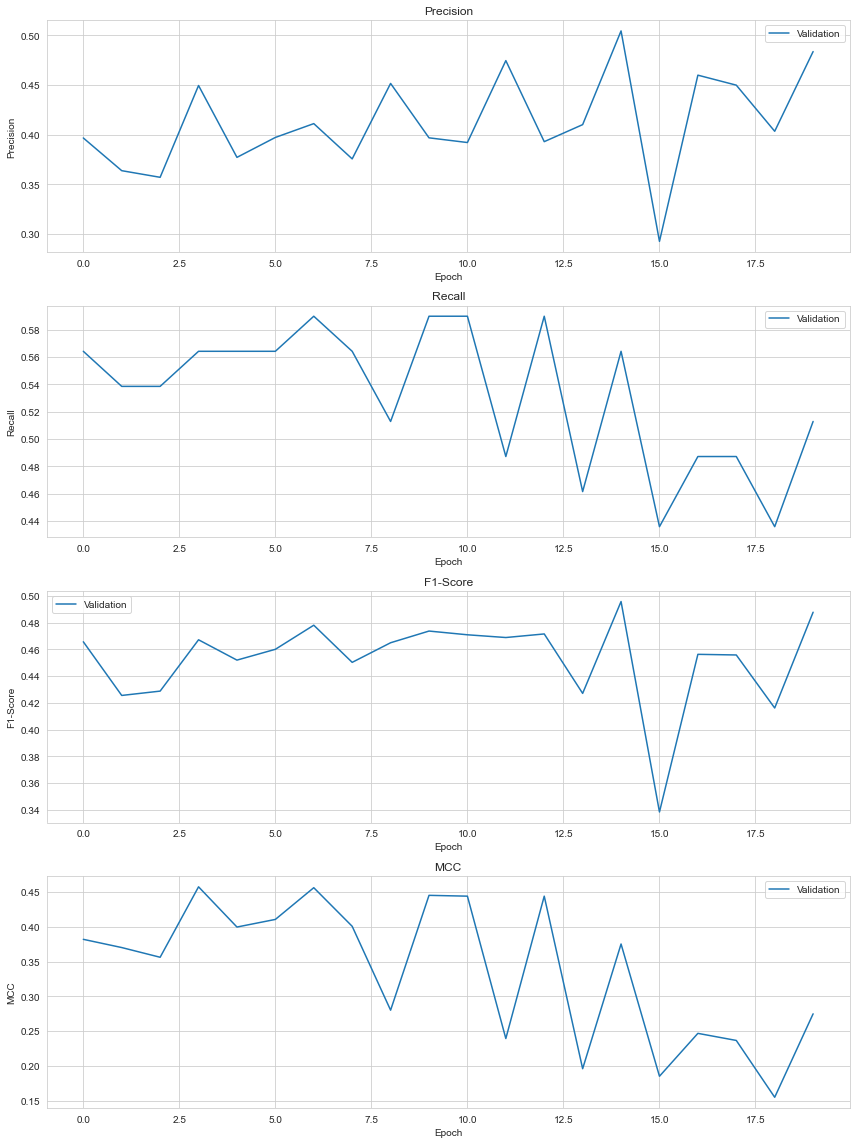

In [14]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 16))

# Precision
ax1.plot(val_precisions, label='Validation')
ax1.set_title('Precision')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Precision')
ax1.legend()

# Recall
ax2.plot(val_recalls, label='Validation')
ax2.set_title('Recall')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Recall')
ax2.legend()

# F1-score
ax3.plot(val_f1_scores, label='Validation')
ax3.set_title('F1-Score')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-Score')
ax3.legend()

# MCC
ax4.plot(val_mccs, label='Validation')
ax4.set_title('MCC')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('MCC')
ax4.legend()

plt.tight_layout()
plt.show()


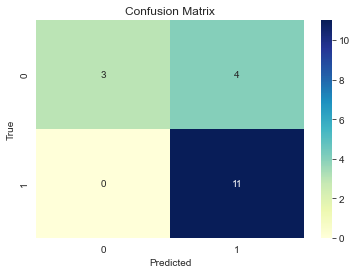

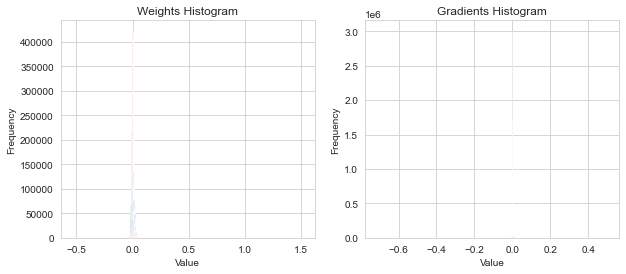

/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


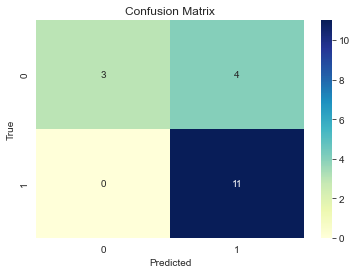

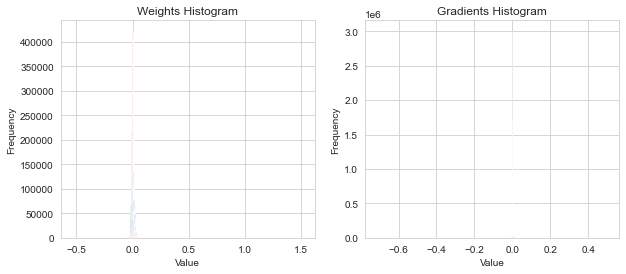

In [15]:
def plot_confusion_matrix(y_true, y_pred, labels, ax=None, title=None):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    if ax is None:
        _, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=ax, xticklabels=labels, yticklabels=labels)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    if title:
        ax.set_title(title)

def get_weights_gradients(model):
    weights = []
    gradients = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            weights.append(param.data.cpu().numpy())
            gradients.append(param.grad.data.cpu().numpy())
    return weights, gradients

def plot_histograms(weights, gradients, figsize=(10, 4)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    for w in weights:
        ax1.hist(w.flatten(), bins=100, alpha=0.5)
    ax1.set_title("Weights Histogram")
    ax1.set_xlabel("Value")
    ax1.set_ylabel("Frequency")

    for g in gradients:
        ax2.hist(g.flatten(), bins=100, alpha=0.5)
    ax2.set_title("Gradients Histogram")
    ax2.set_xlabel("Value")
    ax2.set_ylabel("Frequency")

    plt.show()

# Get true labels and predictions on the validation set
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title="Confusion Matrix")

# Extract weights and gradients and plot histograms
weights, gradients = get_weights_gradients(model)
plot_histograms(weights, gradients)


In [16]:
# Save the trained model
torch.save(model.state_dict(), "CNNModel_speech_music_discrimination.pth")
print("Model saved.")

Model saved.


In [ ]:
# this part doesn't work any more because of the change in the model -> "attention" layer
# Show model summary
try:
    from torchsummary import summary
    print("\nModel summary:")

    original_device = device
    if device == 'mps': # because MPS is not supported by torchsummary
        device = 'cpu'


    class ModelWrapper(nn.Module):
        def __init__(self, module):
            super(ModelWrapper, self).__init__()
            self.module = module

        def forward(self, x):
            return self.module(x)

    model = ModelWrapper(CNNModel(mfcc_dim=32, output_ch=4)).to(device)
    summary(model, input_size=(1, 32, 112))

    if original_device == 'mps': # Restore original device
        device = original_device
        model.to(device)

except ImportError:
    print("\nPlease install torchsummary to display the model summary. Use `pip install torchsummary`.")